# Food segmentation with a U-Net-like architecture

**Description:** Food segmentation model trained from scratch on coco dataset.

In [1]:
!git clone https://github.com/gmurro/FoodRecognition.git

Cloning into 'FoodRecognition'...
remote: Enumerating objects: 50917, done.
remote: Counting objects: 100% (25413/25413), done.
remote: Compressing objects: 100% (2000/2000), done.
remote: Total 50917 (delta 23459), reused 25364 (delta 23412), pack-reused 25504
Receiving objects: 100% (50917/50917), 1.25 GiB | 37.69 MiB/s, done.
Resolving deltas: 100% (23495/23495), done.
Checking out files: 100% (52100/52100), done.


In [2]:
%cd /content/FoodRecognition/src

/content/FoodRecognition/src


## Prepare paths of input images and target segmentation masks

In [1]:
import os

# prepare data for training 

input_train_dir = "../data/train/images/"
masks_train_dir = "../data/train/masks"

img_size = (160, 160)
num_classes = 2
batch_size = 32

input_train_paths = sorted(
    [
        os.path.join(input_train_dir, fname)
        for fname in os.listdir(input_train_dir)
        if fname.endswith(".jpg")
    ]
)

target_train_paths = sorted(
    [
        os.path.join(masks_train_dir, fname)
        for fname in os.listdir(masks_train_dir)
        if fname.endswith(".jpg") and not fname.startswith(".")
    ]
)


for input_path, target_path in zip(input_train_paths[:5], target_train_paths[:5]):
    print(input_path, "|", target_path)

n_train_sample = len(input_train_paths)
print("Number of samples:", n_train_sample)

../data/train/images/006316.jpg | ../data/train/masks\006316.jpg
../data/train/images/006331.jpg | ../data/train/masks\006331.jpg
../data/train/images/006335.jpg | ../data/train/masks\006335.jpg
../data/train/images/006346.jpg | ../data/train/masks\006346.jpg
../data/train/images/006354.jpg | ../data/train/masks\006354.jpg
Number of samples: 24120


In [2]:
# prepare data for validation 

input_val_dir = "../data/val/images/"
masks_val_dir = "../data/val/masks"


input_val_paths = sorted(
    [
        os.path.join(input_val_dir, fname)
        for fname in os.listdir(input_val_dir)
        if fname.endswith(".jpg")
    ]
)

target_val_paths = sorted(
    [
        os.path.join(masks_val_dir, fname)
        for fname in os.listdir(masks_val_dir)
        if fname.endswith(".jpg") and not fname.startswith(".")
    ]
)


for input_path, target_path in zip(input_val_paths[:5], target_val_paths[:5]):
    print(input_path, "|", target_path)

n_val_sample = len(input_val_paths)
print("Number of samples:", n_val_sample)

../data/val/images/006452.jpg | ../data/val/masks\006452.jpg
../data/val/images/006505.jpg | ../data/val/masks\006505.jpg
../data/val/images/006536.jpg | ../data/val/masks\006536.jpg
../data/val/images/006568.jpg | ../data/val/masks\006568.jpg
../data/val/images/006595.jpg | ../data/val/masks\006595.jpg
Number of samples: 1269


## What does one input image and corresponding segmentation mask look like?

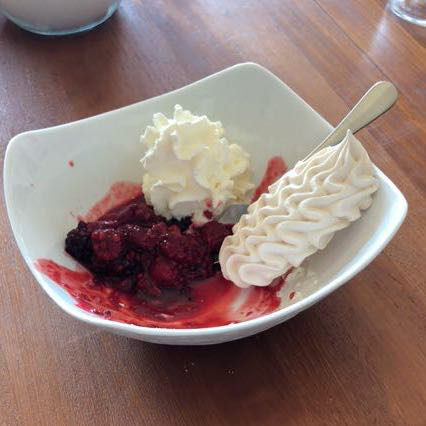

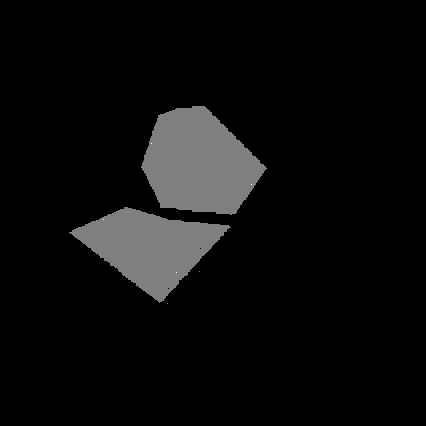

In [3]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tensorflow.keras.preprocessing.image import load_img
from keras.preprocessing.image import ImageDataGenerator as idg
import PIL
from PIL import ImageOps

# Display input image #20
i = 20
img = PIL.Image.open(input_train_paths[i])
display(img)

# Display auto-contrast version of corresponding target (per-pixel categories)
img = PIL.ImageOps.autocontrast(load_img(target_train_paths[i]))
display(img)

In [4]:
from tensorflow import keras
import numpy as np
from tensorflow.keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array


class FoodRecognition(keras.utils.Sequence):
    """Helper to iterate over the data (as Numpy arrays)."""

    def __init__(self, batch_size, img_size, input_img_paths, target_img_paths):
        self.batch_size = batch_size
        self.img_size = img_size
        self.input_img_paths = input_img_paths
        self.target_img_paths = target_img_paths

    def __len__(self):
        return len(self.target_img_paths) // self.batch_size

    def __getitem__(self, idx):
        """Returns tuple (input, target) correspond to batch #idx."""
        i = idx * self.batch_size
        batch_input_img_paths = self.input_img_paths[i : i + self.batch_size]
        batch_target_img_paths = self.target_img_paths[i : i + self.batch_size]
        x = np.zeros((self.batch_size,) + self.img_size + (3,), dtype="float32")
        for j, path in enumerate(batch_input_img_paths):
            img = load_img(path, target_size=self.img_size)
            x[j] = img
        y = np.zeros((self.batch_size,) + self.img_size + (1,), dtype="uint8")
        for j, path in enumerate(batch_target_img_paths):
            img = load_img(path, target_size=self.img_size, color_mode="grayscale")
            y[j] = np.expand_dims(img, 2)
           
        return x, y

Prepare U-Net Xception-style model

In [5]:
from tensorflow.keras import layers


def get_model(img_size, num_classes):
    inputs = keras.Input(shape=img_size + (3,))

    ### [First half of the network: downsampling inputs] ###

    # Entry block
    x = layers.Conv2D(32, 3, strides=2, padding="same")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    # Blocks 1, 2, 3 are identical apart from the feature depth.
    for filters in [64, 128, 256]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(filters, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    ### [Second half of the network: upsampling inputs] ###

    for filters in [256, 128, 64, 32]:
        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.UpSampling2D(2)(x)

        # Project residual
        residual = layers.UpSampling2D(2)(previous_block_activation)
        residual = layers.Conv2D(filters, 1, padding="same")(residual)
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    # Add a per-pixel classification layer
    outputs = layers.Conv2D(num_classes, 3, activation="sigmoid", padding="same")(x)

    # Define the model
    model = keras.Model(inputs, outputs)
    return model


# Free up RAM in case the model definition cells were run multiple times
keras.backend.clear_session()

# Build model
model = get_model(img_size, num_classes)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 80, 80, 32)   896         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 80, 80, 32)   128         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 80, 80, 32)   0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [6]:
from keras.utils.vis_utils import plot_model
plot_model(model, show_shapes=True, show_layer_names=True)

('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')


In [7]:
# Instantiate data Sequences for training and validation set
train_gen = FoodRecognition(batch_size, img_size, input_train_paths, target_train_paths)
val_gen = FoodRecognition(batch_size, img_size, input_val_paths, target_val_paths)

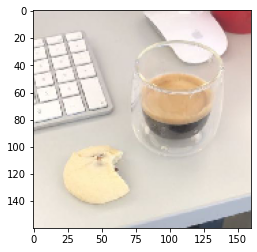

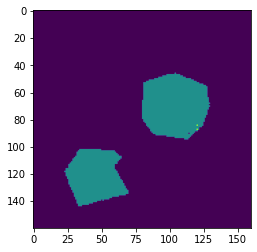

The values in the mask are: [0 1 2]


In [22]:
# print random image
import random

i = random.randint(0,32)
plt.imshow(np.array(val_gen.__getitem__(0)[0][i,:,:,:], dtype = np.uint8))
plt.show()
plt.imshow(val_gen.__getitem__(0)[1][i,:,:,0])
plt.show()
print("The values in the mask are: {}".format(np.unique(val_gen.__getitem__(0)[1][i,:,:,0])))

In [ ]:
# Configure the model for training.
# We use the "sparse" version of categorical_crossentropy
# because our target data is integers.
model.compile(optimizer="adam", loss="binary_crossentropy")

callbacks = [
    #Model checkpoint salva i pesi
    keras.callbacks.ModelCheckpoint("food_segmentation.h5", save_best_only=True)
]

# Train the model, doing validation at the end of each epoch.
epochs = 10
model.fit(train_gen, epochs=epochs, validation_data=val_gen, callbacks=callbacks)

Epoch 1/10
 93/753 [==>...........................] - ETA: 3:16 - loss: 0.8171

[[0.45891303 0.82517594 0.8331989  ... 0.24362284 0.24693446 0.15560637]
 [0.04401018 0.5401446  0.42787206 ... 0.41688544 0.4826546  0.71714497]
 [0.07638442 0.39953727 0.29511413 ... 0.31921795 0.41037086 0.7200728 ]
 ...
 [0.51837915 0.27830172 0.26235956 ... 0.19674797 0.2213552  0.26381004]
 [0.47497982 0.30897036 0.26151654 ... 0.28466526 0.30354267 0.34147182]
 [0.38559404 0.02178186 0.0175837  ... 0.28550774 0.27150363 0.9060974 ]]


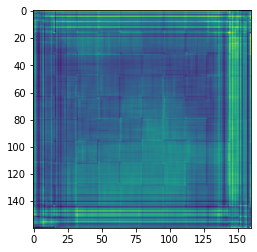

[[0.541087   0.17482406 0.16680111 ... 0.7563771  0.7530655  0.8443936 ]
 [0.95598984 0.45985538 0.5721279  ... 0.58311456 0.51734537 0.28285506]
 [0.9236156  0.6004627  0.70488584 ... 0.6807821  0.5896292  0.27992713]
 ...
 [0.48162085 0.7216983  0.73764044 ... 0.803252   0.7786448  0.73618996]
 [0.5250202  0.69102967 0.7384835  ... 0.7153348  0.6964573  0.65852815]
 [0.614406   0.97821814 0.9824163  ... 0.71449226 0.7284964  0.09390257]]


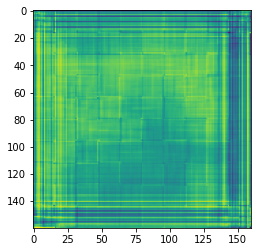

['../data/val/images/041900.jpg', '../data/val/images/087606.jpg', '../data/val/images/069316.jpg', '../data/val/images/052642.jpg', '../data/val/images/061010.jpg', '../data/val/images/009852.jpg', '../data/val/images/102278.jpg', '../data/val/images/050782.jpg', '../data/val/images/073596.jpg', '../data/val/images/058022.jpg', '../data/val/images/069527.jpg', '../data/val/images/093917.jpg', '../data/val/images/082980.jpg', '../data/val/images/086788.jpg', '../data/val/images/099644.jpg', '../data/val/images/037159.jpg', '../data/val/images/100913.jpg', '../data/val/images/079020.jpg', '../data/val/images/057105.jpg', '../data/val/images/078544.jpg', '../data/val/images/008698.jpg', '../data/val/images/060337.jpg', '../data/val/images/070329.jpg', '../data/val/images/020499.jpg', '../data/val/images/069965.jpg', '../data/val/images/085671.jpg', '../data/val/images/084247.jpg', '../data/val/images/040090.jpg', '../data/val/images/052433.jpg', '../data/val/images/012815.jpg', '../data/

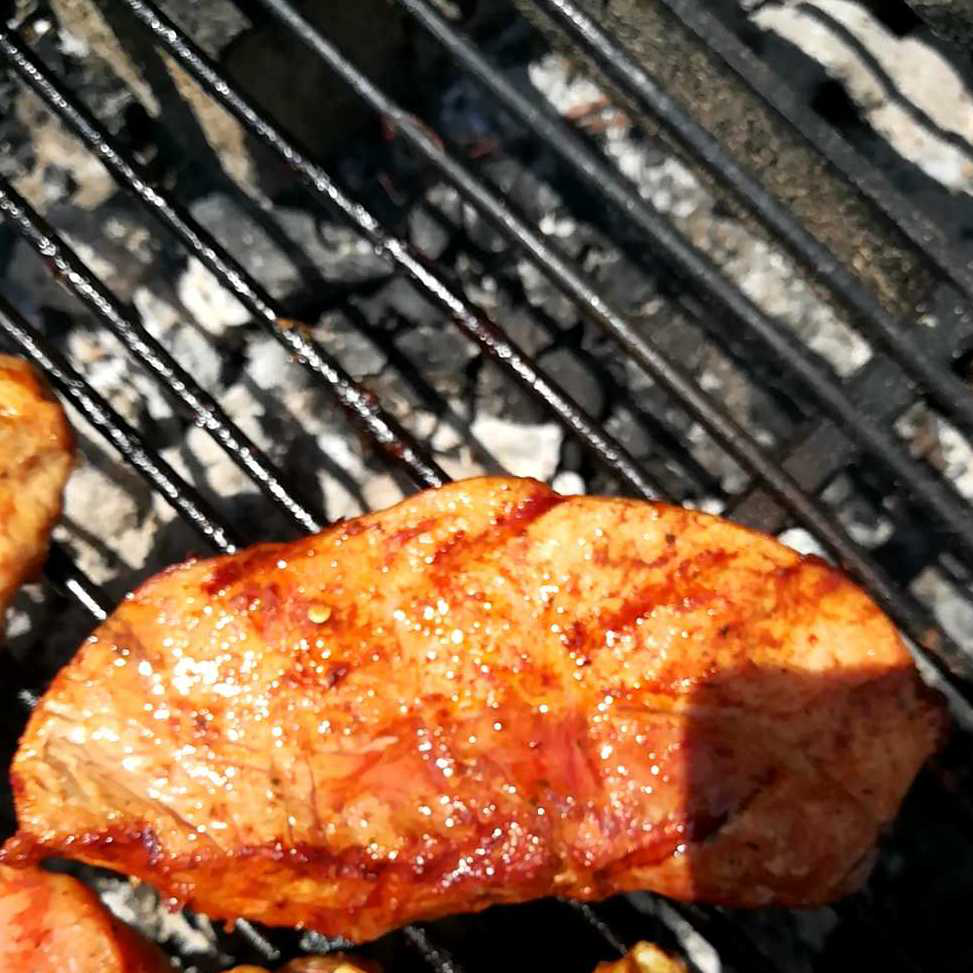

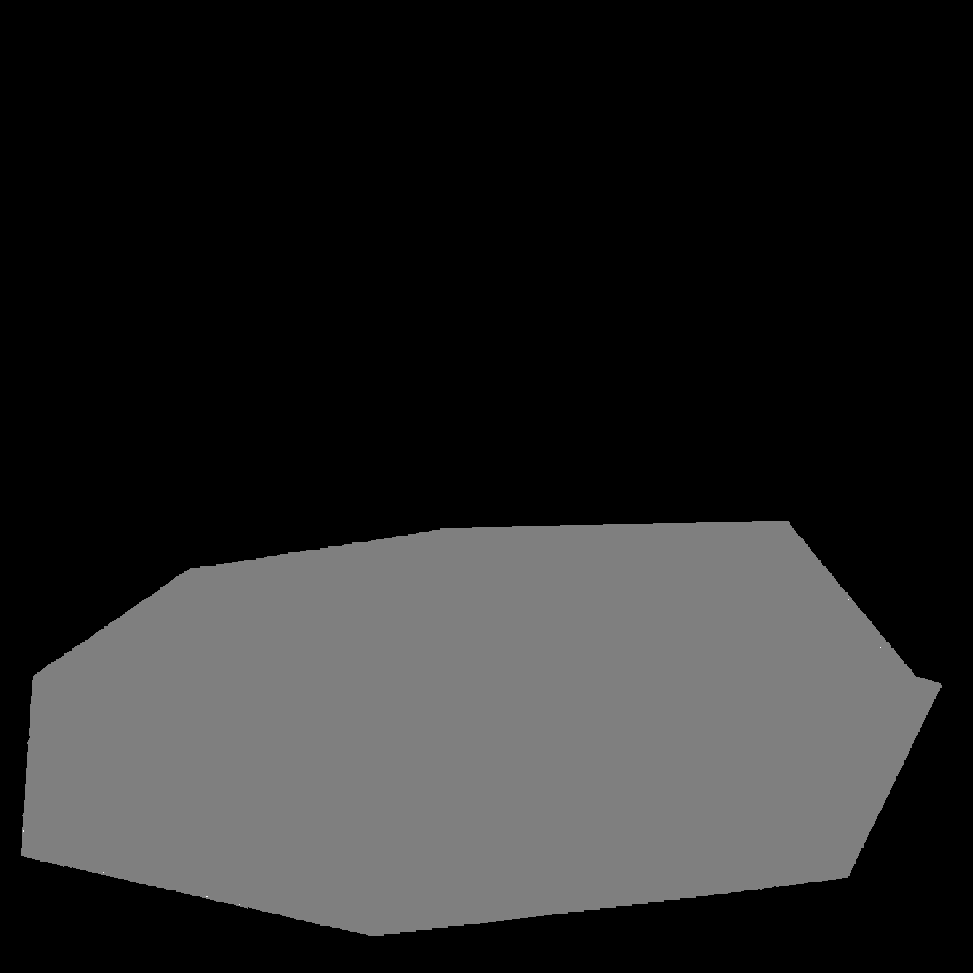

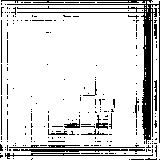

In [48]:
import matplotlib.pyplot as plt

i = 15

val_gen = FoodRecognition(batch_size, img_size, val_input_img_paths, val_target_img_paths)
val_preds = model.predict(val_gen)

print(val_preds[i][:,:,0])
plt.imshow(val_preds[i][:,:,0])
plt.show()

print(val_preds[i][:,:,1])
plt.imshow(val_preds[i][:,:,1])
plt.show()


def display_mask(i):
    """Quick utility to display a model's prediction."""
    mask = np.argmax(val_preds[i], axis=-1)
    mask = np.expand_dims(mask, axis=-1)
    img = PIL.ImageOps.autocontrast(keras.preprocessing.image.array_to_img(mask))
    display(img)


# Display results for validation image #10


# Display input image
print(val_input_img_paths)
display(load_img(val_input_img_paths[i]))
#display(Image(filename=val_input_img_paths[i]))

# Display ground-truth target mask
img = PIL.ImageOps.autocontrast(load_img(val_target_img_paths[i]))
display(img)

# Display mask predicted by our model
display_mask(i)  # Note that the model only sees inputs at 150x150.